In [1]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

In [2]:
solarMass = 1.989e30 # kg
solarRadius = 695.51e6 # meters

# Function evaluates the orbital separation at time t, starting from separation r0.
def separationTimeTScalar(m1, m2, r0, t, G=6.674e-11, c=3e8):
    ts = t*3.154e7 # CONVERT TO SECONDS
    rBase = (4 * -(64.0/5.0) * (G**3/c**5) * (m1*m2)*(m1+m2) * ts  +  r0**4.0)
    
    if rBase < 0:
        return 0
    
    r = rBase**(1.0/4.0)

    if np.isnan(r):
        print("r IS NAN!")
        return 0
    return r

# Function compares separation r with evolved separation r0 after some time t. Returns 1 if within tolerance of similarity.
def forwardedOrbitDelta(r, m1, m2, r0, t, G=6.674e-11, c=3e8, tolFrac=0.005):
    rNew = separationTimeTScalar(m1, m2, r0, t, G, c)
    
    if abs(r-rNew) < tolFrac * rNew: # Return 1 if the forwarded in time r0 equals r.
        return 1
    else:
        return 0

In [3]:
print("Tests:")
print(forwardedOrbitDelta(10e7, solarMass, solarMass, 10e7, t=1.0/3.154e7))
print(forwardedOrbitDelta(10e7, solarMass, solarMass, 10e7, t=25/3.154e7))

print("One second later the distances are deemed close enought to be the same, 25s later and they are not.")

Tests:
1
1
One second later the distances are deemed close enought to be the same, 25s later and they are not.


C:\Users\nicholas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in power


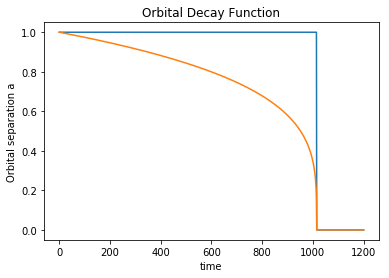

In [4]:
dom = np.linspace(0,1200,1000)
r = orbR(solarMass, solarMass, 10e7, dom, G=6.674e-8, c=3e8, delta=True)
r2 = orbR(solarMass, solarMass, 10e7, dom, G=6.674e-8, c=3e8, delta=False)
plt.plot(dom, r)
plt.plot(dom, r2 / 10e7)
plt.title("Orbital Decay Function")
plt.xlabel('time')
plt.ylabel('Orbital separation a')
plt.show()

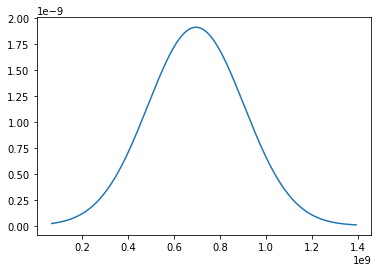

In [5]:
# We want to integrate over the birth-parameter space theta_b.
# We investigate simplest case of one parameter, the birth separation which is distributed as a gaussian which we integrate over:
# https://arxiv.org/pdf/1806.05820.pdf Figure 1 for ballpark radii and masses for birth BNS
pi_ab = lambda a_b: scipy.stats.norm(1*solarRadius, 0.3*solarRadius).pdf(a_b)

plt.plot(np.linspace(0.1*solarRadius, 2*solarRadius, 1000), pi_ab(np.linspace(0.1*solarRadius, 2*solarRadius, 1000)))
plt.show()

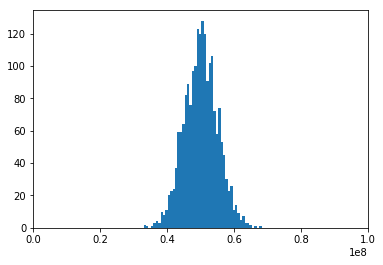

In [36]:
a_bPop = np.random.normal(5e7, 0.1*5e7, 2000)
#a_bPop = np.random.normal(10e9, 0.05*10e9, 2000)

plt.hist(a_bPop, bins=np.linspace(min(a_bPop), max(a_bPop), 50))
plt.xlim(0,10e7)
plt.show()

In [37]:
# Frame output requires folder "./animation/"

# Change to True to create animation frames
if True:
    Nframes=200

    plt.cla()
    for i, t in enumerate(np.linspace(0, 2000, Nframes)):
        plt.clf()

        if i % 20 == 0:
            print("Generating frame {}".format(i))

        a_tList = []
        for a_b in a_bPop:
            a_t = separationTimeTScalar(1.4*solarMass, 1.4*solarMass, a_b, t)
            a_tList.append(a_t)

        plt.hist(a_tList, bins=np.linspace(0, 1.4*np.max(a_b), 100), color='red')
        plt.xlim(0,8e7)
        plt.ylim(0,180)

        plt.xlabel("Binary Separation (m)")
        plt.title("Separation Distribution at t={} years".format(round(t)))
        plt.savefig('animation/{}.png'.format(i))
    print("Done!")

Generating frame 0
Generating frame 20
Generating frame 40
Generating frame 60
Generating frame 80
Generating frame 100
Generating frame 120
Generating frame 140
Generating frame 160
Generating frame 180
Done!


In [38]:
# CHANGE TO TRUE IF YOU WANT TO PRODUCE GIF
if False:
    import imageio
    import os
    images = []

    saveloc = 'animation'

    filenames = [saveloc + '/{}.png'.format(i) for i in range(0, Nframes)]

    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('animation/animated3.gif', images)

We wish to investigate the probabilities of separation a_x at time t, given a birth parameter population $a_b\in\theta_b$. To do so:  

$\pi_t(\theta_x|\Lambda_b)=\int dt \int d\theta_b \pi(t) \pi(\theta_x|\theta_b,t) \pi(\theta_b|\Lambda_b)$

OR in 1D:

$\pi_t(a_x|\Lambda_b)=\int dt \int da_b \pi(t) \pi(a_x|a_b,t) \pi(a_b|\Lambda_b)$

We loop over a range of present separations a_x; then the above integral is calculated by discretising the a_b integral. This is done by sampling (at even intervals) the above hierarchical model which describes the birth parameters, then the integrand is computed using $\pi(a_x|a_b,t)$ to act like a delta function which "combs" for whether $a_b\rightarrow a_x$ after some time t (return 1 if evolved a_b=a_x). 

Currently the code is too slow to cover the domain a_x at fine precision do to the inner loop over all the birth separations. I am thinking is damaging as the $\pi(a_x|a_b,t)$ delta function misses orbits which actually have probablity? perhaps explaining the a_xPr results all being the same ~1% due to accumulated errors?

I think this should be faster by properly numerically integrating both integrals, however I am not sure how to do this in the same step as the time evolution of the birth parameters, as these birth parameters are also integrated over. Perhaps consider alternating order of integration

Currently exploring increasing separation distance similarity tolerance, changing density of a_b population and of a_x spacing.


In [39]:
%xmode

Exception reporting mode: Plain


In [74]:
# Change to True to run
if False:
    #### 
    TOLERANCE = 0.05 # a_x and evolved a_b will be considered the same if abs(r1-r2)<tolFrac*r1
    verbose = False

    # We want to integrate from time t_i to t_f
    t_i, t_f = 0.0, 1200.0 # Time integrated over (years)

    #### Flat time distribution
    pi_t = lambda t: scipy.stats.uniform(t_i, t_f-t_i).pdf(t)
    ####

    ######### pi_thetaX_given_thetaB_t should be like a delta function at time t.
    pi_thetaX_given_thetaB_t = lambda a_x, a_b, t: forwardedOrbitDelta(a_x, 1.4*solarMass, 1.4*solarMass, a_b, t, tolFrac=TOLERANCE)
    #########

    ######## Probability of model parameters
    pi_thetaB_given_LambdaB = lambda a_b: pi_ab(a_b)
    ########

    #########
    integrand = lambda a_x, a_b, t: pi_t(t) * pi_thetaX_given_thetaB_t(a_x, a_b, t) * pi_thetaB_given_LambdaB(a_b)
    #########

    # To integrate over a discretised birth population we first need to create birth pop:
    a_bPop = np.random.normal(5e7, 0.1*5e7, 100)
    a_bMax = np.max(a_bPop)

    # We want to perform this integral over a range of potentially observable systems with some parameter set theta_x at time t.
    # In this 1D case we look at just a range of 20 values of a_x from 0 to a_bMax
    # Not anymore, we look in some area around:
    a_xDomain = np.linspace(0, a_bMax, 100)

    prList = []
    for tRunTime in np.linspace(0, 2000, 5): # We look over t=1200 years to t=2000
    #for tRunTime in [1500]: 
        print("Completing tMax of {} years".format(tRunTime))

        # Empty list to store each probability.
        a_xPr = []

        # For each possible new a_x 
        for i, a_x in enumerate(a_xDomain):
            print("Calculating the probability of parameters a_x={} at time {}".format(a_x, tRunTime))
            print("%{} completed.".format(100*float(i)/len(a_xDomain)))

            # First integrating over a_b domain (birth parameters)
            a_bIntegralTotal = 0

            # For each NS at birth:
            for a_b in a_bPop:

                integrandArgumented = lambda t: integrand(a_x, a_b, t) # So we can use it as a function of t below:

                try: # Sometimes there is an error...
                    # Take [0] as this is the integral result, [1] is the error.
                    integralResult = scipy.integrate.quad(integrandArgumented, t_i, tRunTime)[0] #* a_bDelta
                    a_bIntegralTotal += integralResult

                    if integralResult > 0:
                        if verbose:
                            print("a_x, a_b == ", a_x, a_b)
                            print("!!!!!!!!!!!Found contribution!!!!!!!!!!!! {}".format(integralResult))
                except Exception as e:
                    print(e)


            # Join probability onto end of list
            a_xPr.append(a_bIntegralTotal)

        prList.append(a_xPr)

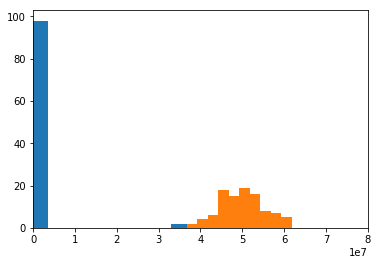

In [58]:
a_tList = []
for a_b in a_bPop:
    a_t = separationTimeTScalar(1.4*solarMass, 1.4*solarMass, a_b, 1500)
    #print(a_t, a_b)
    a_tList.append(a_t)
    
plt.hist(a_tList)
plt.hist(a_bPop)
plt.xlim(0,8e7)
plt.show()

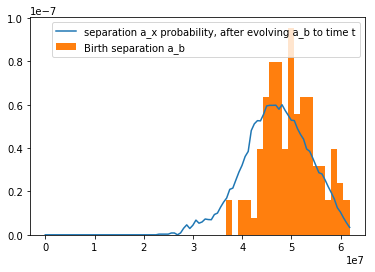

In [59]:
# Hacked normalisation
normedPr = [6e-8*float(i)/max(a_xPr) for i in a_xPr]
plt.plot(a_xDomain, normedPr)
plt.hist(a_bPop, normed=True, bins=20) # NORMED WORKING?
plt.legend(["separation a_x probability, after evolving a_b to time t", "Birth separation a_b"])
plt.show()

In [69]:
prArray = np.array(prList)
print(prArray.shape)

(10, 100)


C:\Users\nicholas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


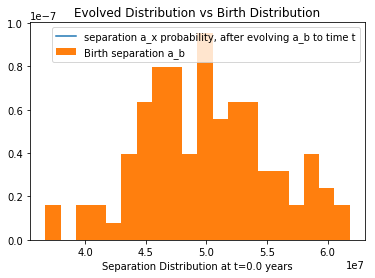

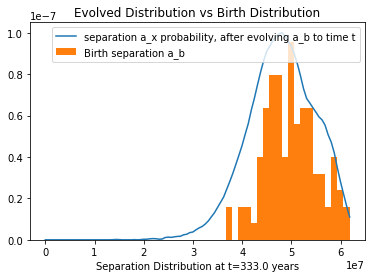

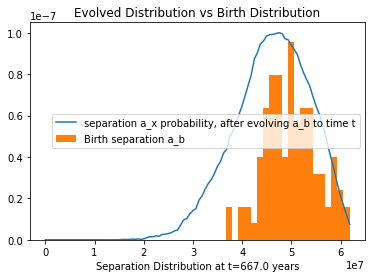

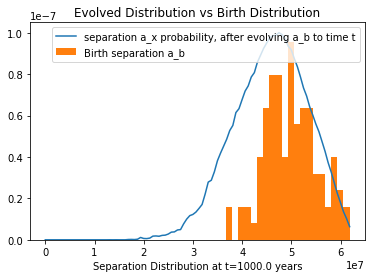

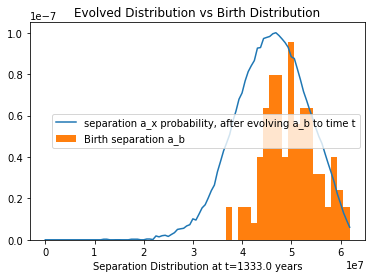

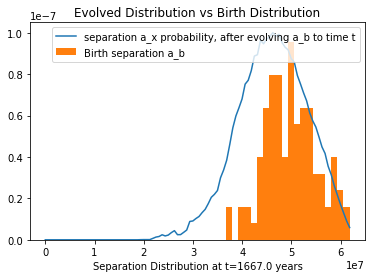

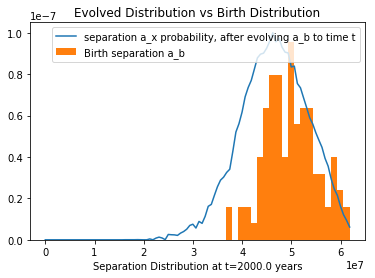

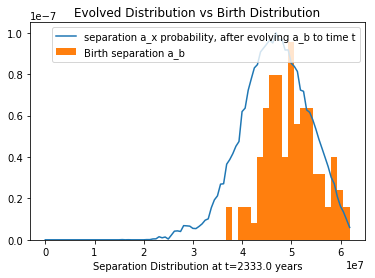

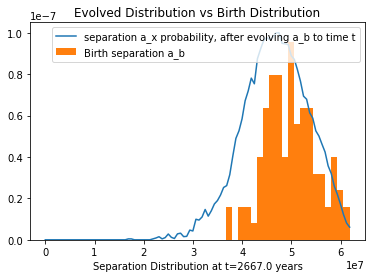

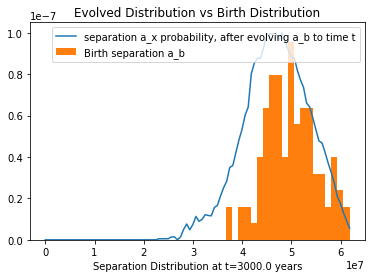

In [81]:
yearList = [round(year) for year in np.linspace(0, 3000, 10)]

for i, a_xPr2 in enumerate(prArray):
    # Hacked normalisation
    normedPr = [1e-7*float(i)/(max(a_xPr2)) for i in a_xPr2]
    
    plt.plot(a_xDomain, normedPr)
    plt.hist(a_bPop, normed=True, bins=20) # NORMED WORKING?
    plt.legend(["separation a_x probability, after evolving a_b to time t", "Birth separation a_b"])
    year = yearList[i]
    plt.xlabel("Separation Distribution at t={} years".format(year))
    plt.title("Evolved Distribution vs Birth Distribution".format(year))
    plt.show()

We want $\pi(a_x|a_b,t)$ to act like a delta function, returning the ~~probability of the separation a_x at time t given the birth parameters.~~ OR returning 0 or 1 depending if a_x=a_b after time forwarding or not? ~~**Either way I think this needs to be discretized to do some forwarding in time? or at least to do root finding of the orbitDecay function to then know where to place a delta function.**~~

~~I discretize the integral in time t, so that for each step we are able to 'play forward' the current distribution of birth parameters $a_b\in\theta_b$, then create a kernal estimation of the new distribution to create an interpolated probability distribution.~~


In [16]:
x = separationTimeTScalar(1.4*solarMass, 1.4*solarMass, 8617272779.264553, 1200)
print(x)

# 8617272779.264553 8451992321.032602

8617272775.264975
